In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from mytorch.optim import SGD
# from mytorch.utils import DataLoader
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import random
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor
import warnings
# warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", "MPS available but not used")
warnings.filterwarnings("ignore", ".*You defined a.*")
warnings.filterwarnings("ignore", ".*IOPub message rate.*")
warnings.filterwarnings("ignore", ".*Current values.*")


In [2]:
# Load Raw Data
words = open('names.txt', 'r').read().splitlines()
print(f'Number of names: {len(words)}')
print(
    f'Median name length: {torch.median(torch.tensor(list(len(w) for w in words))).item()}')
print(f'Max name length: {max(len(w) for w in words)}')
print(f'Example names: {words[:8]}')

# build the vocapbulary of charactors mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


Number of names: 32033
Median name length: 6
Max name length: 15
Example names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [3]:
# Make Dataset and data loaders

block_size = 3


class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, words):
        'Initialization'
        X, Y = [], []

        for w in words:
            context = [0] * block_size
            for ch in w + '.':
                ix = stoi[ch]
                X.append(context)
                Y.append(ix)
                context = context[1:] + [ix]

        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.Y)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # ID = self.target[index]

        # Load data and get label
        X = self.X[index]
        y = self.Y[index]

        return X, y


random.seed(42)
random.shuffle(words)
batch_size = 64
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
# train_data = Dataset(Xtr,Ytr)
# valid_data = Dataset(Xdev,Ydev)
train_data = Dataset(words[:n1])  # 80%
valid_data = Dataset(words[n1:n2])  # 10%
test_data = Dataset(words[n2:])  # 10%

data = DataLoader(train_data, batch_size=batch_size)
data_dev = DataLoader(valid_data, batch_size=batch_size)


In [4]:
# Define Model

torch.manual_seed(42)
n_embd = 10
n_hidden = 200
batch_size = 64


class MakeMore(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Embedding(vocab_size, n_embd),
            nn.Flatten(),
            nn.Linear(n_embd*block_size, n_hidden,
                      bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, vocab_size))
        self.batch_size = 64
        self.learning_rate = 0.03

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        # self.log('train_loss', loss)
        self.log("train_loss", loss, prog_bar=False,
                 on_step=False, on_epoch=True,enable_graph=True)
        #self.log("my_lr",lr-SGD, prog_bar=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        # self.log('train_loss', loss)
        self.log("val_loss", loss, prog_bar=True,
                 on_step=False, on_epoch=True,batch_size=128)
        
        return loss

    def predict_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # x, y = batch
        x = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2) 
        lr_scheduler = {"scheduler": scheduler, "interval": "epoch", "monitor": "val_loss"}
        return [optimizer], [lr_scheduler]


makemore = MakeMore()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jsmidt/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
Missing logger folder: /Users/jsmidt/Documents/AI/scratch/makemore/lightning_logs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /Users/jsmidt/Documents/AI/scratch/makemore/.lr_find_5c1b503a-09b2-4758-8541-682017ae3b4e.ckpt
Restored all states from the checkpoint file at /Users/jsmidt/Documents/AI/scratch/makemore/.lr_find_5c1b503a-09b2-4758-8541-682017ae3b4e.ckpt
/var/folders/g3/s8dw43sn4cbb99pp7s3zn8vc0008fx/T/ipykernel_61478/1213090020.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.15848931924611143


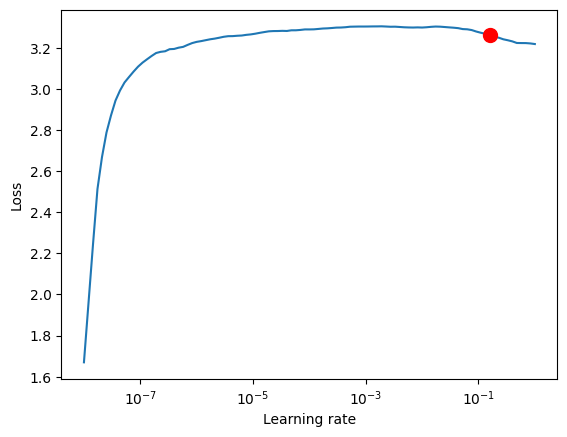

In [5]:
# run learning rate finder, results override hparams.learning_rate
trainer = pl.Trainer(auto_lr_find=True)

# call tune to find the lr
#lr_finder = trainer.tune(makemore, train_dataloaders=data)
lr_finder = trainer.tuner.lr_find(makemore, train_dataloaders=data)

# Results can be found in
#print(lr_finder.results)
print (lr_finder.suggestion())

fig = lr_finder.plot(suggest=True)
fig.show()

In [6]:
# Define traner and train
# trainer = pl.Trainer(max_epochs=5,accelerator="mps",callbacks=[RichProgressBar(refresh_rate=200)])
# trainer = pl.Trainer(max_epochs=10,accelerator="mps",callbacks=[TQDMProgressBar(refresh_rate=1000)])
# trainer = pl.Trainer(max_epochs=10,enable_progress_bar=False)

#trainer = pl.Trainer(max_epochs=40, callbacks=[
#                     TQDMProgressBar(refresh_rate=400),LearningRateMonitor(logging_interval='epoch')])
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(max_epochs=100, callbacks=[TQDMProgressBar(refresh_rate=400),lr_monitor])
trainer.fit(model=makemore, train_dataloaders=data, val_dataloaders=data_dev)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/jsmidt/Documents/AI/scratch/makemore/lightning_logs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 12.1 K
-------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [7]:
pwd

'/Users/jsmidt/Documents/AI/scratch/makemore'

In [7]:
# Validate data
print('Final loss on training set is: ', trainer.validate(
    model=makemore, dataloaders=data))
print('Final loss on validation set is: ', trainer.validate(
    model=makemore, dataloaders=data_dev))


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.057190179824829     │
└───────────────────────────┴───────────────────────────┘

Final loss on training set is:  [{'val_loss': 2.057190179824829}]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.108419418334961     │
└───────────────────────────┴───────────────────────────┘

Final loss on validation set is:  [{'val_loss': 2.108419418334961}]


In [29]:
# This Should work
x = train_data[:1][0]
print (x, x.shape)

# What about this?
context = [0,0,0]
x = torch.tensor([context])
print (x, x.shape)

makemore.model.eval()

print (makemore.model(x))

#batch = next(iter(data))
#x, y = batch
#print (x)
#trainer.predict(makemore,x)

#trainer.predict()


tensor([[0, 0, 0]]) torch.Size([1, 3])
tensor([[0, 0, 0]]) torch.Size([1, 3])
tensor([[-6.6805,  1.7537,  0.7105,  0.6615,  0.4226,  1.2999, -0.1599, -0.2810,
          0.9469, -0.0277,  1.2543,  1.7956,  1.3231,  1.6305,  0.6792, -0.3639,
         -0.1842, -1.9578,  0.8891,  1.0497,  0.8093, -2.1067, -0.7126, -0.6525,
         -1.7903, -0.3205,  0.3402]], grad_fn=<AddmmBackward0>)


In [8]:
makemore.model.eval()
with torch.no_grad():
    for _ in range(20):

        out = []
        context = [0] * block_size
        while True:
            x = torch.tensor([context])
            logits = makemore.model(x)

            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()

            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itos[i] for i in out))

berlea.
ladell.
rockai.
loven.
laykreya.
adriel.
gion.
malin.
sustavyante.
asabellandressa.
thanna.
dole.
givie.
talliet.
hattistin.
level.
atorman.
maya.
yam.
men.


In [ ]:
%tensorboard 